In [1]:
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz

--2020-01-20 06:34:23--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 52.219.73.150
Connecting to fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)|52.219.73.150|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4422102 (4.2M) [binary/octet-stream]
Saving to: ‘t10k-images-idx3-ubyte.gz.1’

t10k-images-idx3-ub 100%[===================>]   4.22M  1.80MB/s    in 2.3s    

2020-01-20 06:34:26 (1.80 MB/s) - ‘t10k-images-idx3-ubyte.gz.1’ saved [4422102/4422102]

--2020-01-20 06:34:29--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 52.219.74.78
Connecting to fashion-mnist.s3-website.eu-central-1.amazona

In [2]:
!pip install idx2numpy

In [3]:
import gzip, idx2numpy
import numpy as np

images_archive = gzip.open('train-images-idx3-ubyte.gz', 'r')
labels_archive = gzip.open('train-labels-idx1-ubyte.gz', 'r')
test_img_archive = gzip.open('t10k-images-idx3-ubyte.gz', 'r')
test_lbl_archive = gzip.open('t10k-labels-idx1-ubyte.gz', 'r')

images = idx2numpy.convert_from_file(images_archive)
labels = idx2numpy.convert_from_file(labels_archive)
test_images = idx2numpy.convert_from_file(test_img_archive)
test_labels = idx2numpy.convert_from_file(test_lbl_archive)

images.shape, labels.shape, test_images.shape, test_labels.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [0]:
import matplotlib.pyplot as plt

def show_img(img, title=None, figsize=None, ax=None):
  if not ax: fig,ax = plt.subplots(figsize=figsize)
  if str(title): ax.set_title(title)
  ax.imshow(img, cmap='gray')
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  return ax

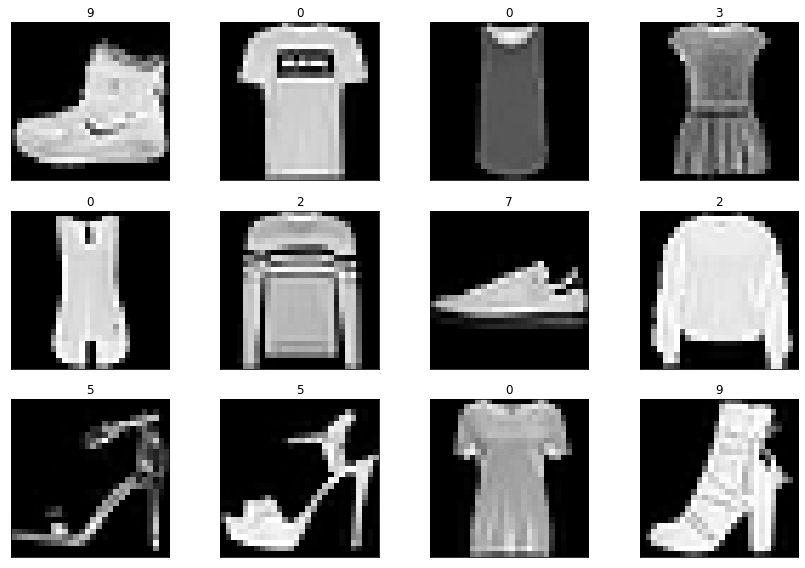

In [5]:
fig, axes = plt.subplots(3, 4, figsize=(12,8))
for i, ax in enumerate(axes.flat):
  img = images[i]
  label = labels[i]
  ax = show_img(img, title=label, ax=ax)
plt.tight_layout()

In [0]:
X_train = images[:48000]
Y_train = labels[:48000]
X_val = images[48000:]
Y_val = labels[48000:]

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import normalize
device = 'cuda'

In [0]:
class FashionDataset(Dataset):
  def __init__(self, X, Y):
    self.X = X
    self.Y = Y

  def __len__(self):
    return self.X.shape[0]

  def __getitem__(self, i):
    #load 2d array, normalize to 0-1 range, transform it to tensor
    x = self.X[i]
    x = normalize(x,axis=0)
    x = torch.from_numpy(x)[None].float().to(device)
    y = self.Y[i]
    y = torch.Tensor([y]).long().to(device)
    return (x, y)

In [0]:
train = FashionDataset(X_train, Y_train)
val = FashionDataset(X_val, Y_val)
test = FashionDataset(test_images, test_labels)

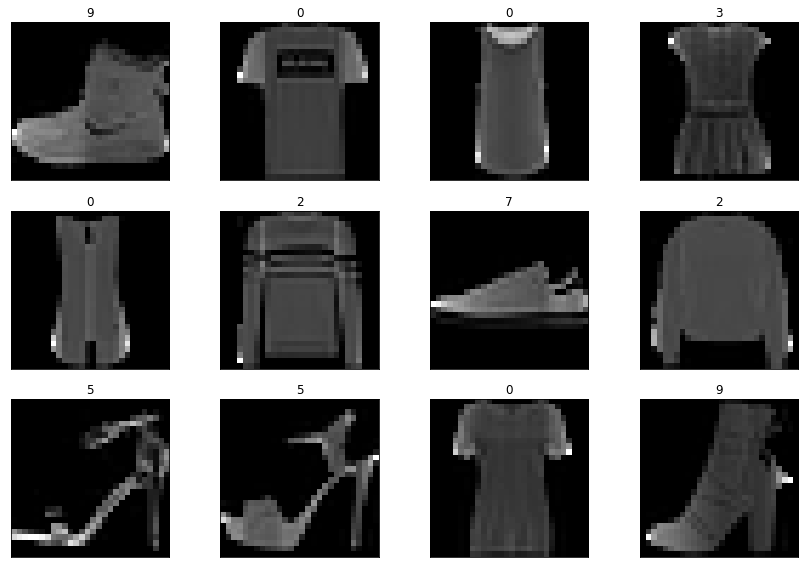

In [10]:
fig, axes = plt.subplots(3, 4, figsize=(12,8))
for i, ax in enumerate(axes.flat):
  img, label = train[i]
  img = img.cpu().detach().numpy()[0]
  label = label.cpu().detach().numpy()[0]
  ax = show_img(img, title=label, ax=ax)
plt.tight_layout()

In [0]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(1, 6, 5)
    self.conv2 = nn.Conv2d(6, 12, 5)

    self.fc1 = nn.Linear(4800, 128)
    self.fc2 = nn.Linear(128, 10)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    
    x = x.view(-1, 4800)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x

In [0]:
bs = 256

train_loader = DataLoader(train, bs, True)
val_loader = DataLoader(val, bs, True)
test_loader = DataLoader(test, bs, True)

model = CNN().cuda()
optim = torch.optim.Adam(model.parameters(), lr=1e-2)
criterion = nn.CrossEntropyLoss()

In [13]:
from torchsummary import summary
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 24, 24]             156
            Conv2d-2           [-1, 12, 20, 20]           1,812
            Linear-3                  [-1, 128]         614,528
            Linear-4                   [-1, 10]           1,290
Total params: 617,786
Trainable params: 617,786
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 2.36
Estimated Total Size (MB): 2.42
----------------------------------------------------------------


In [0]:
def train_model(model, n_epochs, lr, bs=bs):
  optim.param_groups[0]['lr'] = lr

  train_batches = len(train_loader)
  len_train = train_batches*bs
  val_batches = len(val_loader)
  len_val = val_batches*bs

  for epoch in range(n_epochs):
    print(f'Epoch: {epoch+1}/{n_epochs}')

    #train loop
    model.train()
    train_loss = 0
    train_acc = 0
    for i, (x, y) in enumerate(train_loader, 1):
      y = y.squeeze(1)
      optim.zero_grad()
      pred = model(x)
      loss = criterion(pred, y)
      loss.backward()
      optim.step()
      train_loss += loss.item()
      batch_acc = (torch.argmax(pred, -1)==y).sum().float()/y.shape[0]
      train_acc += batch_acc
      print(f'\rTrain loss: {train_loss/i:.4f}; train acc: {train_acc/i:.4f}; batch: {i}/{train_batches}', end='')

    #eval loop
    print('')
    model.eval()
    val_loss = 0
    val_acc = 0
    for i, (x, y) in enumerate(val_loader, 1):
      y = y.squeeze(1)
      pred = model(x)
      loss = criterion(pred, y)
      val_loss += loss.item()
      batch_acc = (torch.argmax(pred, -1)==y).sum().float()/y.shape[0]
      val_acc += batch_acc
      print(f'\rVal loss: {val_loss/i:.4f}; val acc: {val_acc/i:.4f}; batch: {i}/{val_batches}', end='')
    print('\n')

In [16]:
train_model(model, 4, 1e-2)

Epoch: 1/4
Train loss: 0.5902; train acc: 0.7819; batch: 188/188
Val loss: 0.3855; val acc: 0.8588; batch: 47/47

Epoch: 2/4
Train loss: 0.3372; train acc: 0.8756; batch: 188/188
Val loss: 0.3206; val acc: 0.8827; batch: 47/47

Epoch: 3/4
Train loss: 0.2932; train acc: 0.8909; batch: 188/188
Val loss: 0.3172; val acc: 0.8842; batch: 47/47

Epoch: 4/4
Train loss: 0.2569; train acc: 0.9030; batch: 188/188
Val loss: 0.3131; val acc: 0.8852; batch: 47/47



In [17]:
train_model(model, 4, 1e-4)

Epoch: 1/4
Train loss: 0.2025; train acc: 0.9266; batch: 188/188
Val loss: 0.2865; val acc: 0.8958; batch: 47/47

Epoch: 2/4
Train loss: 0.1886; train acc: 0.9309; batch: 188/188
Val loss: 0.2846; val acc: 0.8969; batch: 47/47

Epoch: 3/4
Train loss: 0.1830; train acc: 0.9325; batch: 188/188
Val loss: 0.2828; val acc: 0.8980; batch: 47/47

Epoch: 4/4
Train loss: 0.1793; train acc: 0.9333; batch: 188/188
Val loss: 0.2823; val acc: 0.8983; batch: 47/47



In [18]:
train_model(model, 4, 1e-5)

Epoch: 1/4
Train loss: 0.1763; train acc: 0.9348; batch: 188/188
Val loss: 0.2823; val acc: 0.8986; batch: 47/47

Epoch: 2/4
Train loss: 0.1757; train acc: 0.9350; batch: 188/188
Val loss: 0.2822; val acc: 0.8987; batch: 47/47

Epoch: 3/4
Train loss: 0.1755; train acc: 0.9353; batch: 188/188
Val loss: 0.2823; val acc: 0.8986; batch: 47/47

Epoch: 4/4
Train loss: 0.1751; train acc: 0.9354; batch: 188/188
Val loss: 0.2819; val acc: 0.8988; batch: 47/47



In [0]:
import seaborn as sn
from sklearn.metrics import confusion_matrix

In [0]:
def test_model(model):
  
  model.eval()
  test_acc = 0
  len_test = len(test_loader)
  preds = torch.Tensor(0).to(device)
  Ys = torch.LongTensor(0).to(device)
  for i, (x, y) in enumerate(test_loader, 1):
    y = y.squeeze(1)
    pred = model(x)
    preds = torch.cat((preds, torch.argmax(pred, -1).float()))
    Ys = torch.cat((Ys, y))
    print(f'\rProcessing batch: {i}/{len_test}', end='')

  test_acc = (preds==Ys).sum().float()/len(test_loader.dataset)
  print(f'\rTest accuracy: {test_acc:.4f}')

  cm = confusion_matrix(preds.cpu(),Ys.cpu())
  plt.figure(figsize=(12,9))
  sn.heatmap(cm, annot=True, fmt='d')

Test accuracy: 0.8956


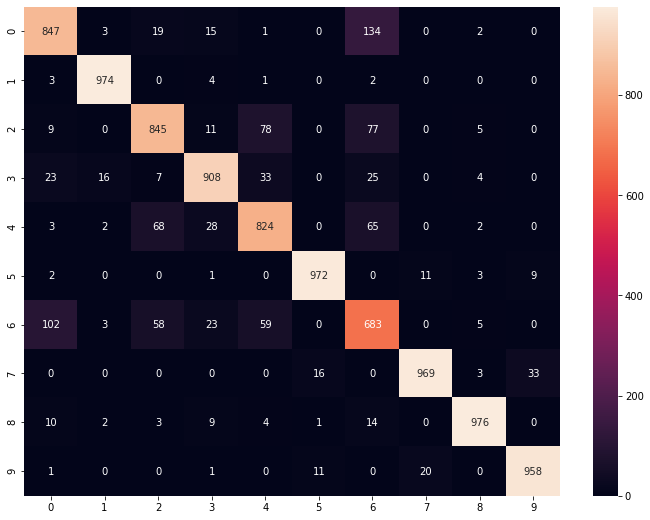

In [21]:
test_model(model)